In [26]:
LIB_DIR = '/home/yuning/Work/cs-273/src/'
import sys
if LIB_DIR not in sys.path:
    sys.path.insert(0, LIB_DIR)

import importlib
from pprint import pprint
from ref.atminter.lib.modules.paperparse import SpFile
import pandas as pd
import numpy as np
import util
import os
import glob

# Export dataset for Bert

In [29]:
class Abstract(object):

    def __init__(self, id, label=None, title=None, abstract=None):
        self.id = id
        if label is not None:
            self.label = label
        if title is not None:
            self.title = title
        if abstract is not None:
            self.abstract = abstract

class AnnData(object):

    def __init__(self, abs_list):
        self.dataset = abs_list
        pass
    
    @staticmethod
    def read_ann_file(file_dirc, ix=0):
        """function to read .ann file and convert to a list of Abstract objects
        """
        import os
        
        print('Load file {}...'.format(os.path.basename(file_dirc)))
        label_map = {
            'F': 0,
            'T': 1
        }
        
        dataset = []
        with open(file_dirc) as handle:
            while True:
                try:
                    label = next(handle)
                except StopIteration:
                    break  #EoF
                label = label_map[label[1].upper()]
                title = next(handle)
                if title[:4] == 'TI  ':
                    title = title[6:]
                if title[0] == '[' and title[-1] == ']':
                    title = title[1:-1]
                abstract = next(handle)
                if abstract[:4] == 'AB  ':
                    abstract = abstract[6:]
                dataset.append(Abstract(id=ix, label=label, title=title, abstract=abstract))
                ix += 1
        return dataset    
    
    @classmethod
    def from_ann_file(cls, file_dirc):
        """Create a dataset from .ann file
        """
        
        dataset = cls.read_ann_file(file_dirc)
        return cls(dataset)
        
    def add_ann_file(self, file_dirc, inplace=True):
        import os
        """Append dataset with new .ann file"""
        
        self.dataset += self.read_ann_file(file_dirc)
    
    def overview(self):
        """Print out overview of dataset"""
        print('Dataset size: {}'.format(len(self.dataset)))
        print('Positive: {}\nNegative: {}'.format(
            len([1 for data in self.dataset if data.label == 1]),
            len([1 for data in self.dataset if data.label == 0])
        ))
        
    def train_dev_test_split(self, ratio=(0.8, 0.1, 0.1), random_state=23, save_dirc=None):
        """Split dataset into train, dev, and test set.
        Export as .tsv file if applicable, otherwise return three split datasets
        """
        
        from sklearn.model_selection import train_test_split
        import os
        
        train = AnnData()
        dev = AnnData()
        test = AnnData()
        train.dataset, test.dataset = train_test_split(self.dataset,
                                                       train_size=ratio[0], test_size=1 - ratio[0],
                                                       random_state=random_state,
                                                       stratify=[data.label for data in self.dataset])
        dev.dataset, test.dataset = train_test_split(test.dataset,
                                                     train_size=ratio[1]/(ratio[1] + ratio[2]),
                                                     test_size=ratio[2]/(ratio[1] + ratio[2]),
                                                     random_state=random_state,
                                                     stratify=[data.label for data in test.dataset])
        if save_dirc is not None:
            if not os.path.isdir(save_dirc):
                os.mkdir(save_dirc)
            train.to_tsv(save_dirc + '/train.tsv')
            dev.to_tsv(save_dirc + '/dev.tsv')
            test.to_tsv(save_dirc + '/test.tsv')
        else:
            return train, dev, test
    
    def KFold_split(self, k=10, save_data_to=None):
        """Generate stratified K-Fold cross-validator
        """
        from sklearn.model_selection import StratifiedKFold
        import os
        
        SKFold = StratifiedKFold(n_splits=k, random_state=23, shuffle=True)
        
        if save_data_to:
            if not os.path.exists(save_data_to):
                os.makedirs(save_data_to)
        else:
            k_fold_buffer = []
        for set_ix, (train_index, test_index) in enumerate(SKFold.split(X=np.zeros(len(dataset)),
                                                                        y=[data.label
                                                                           for data in self.dataset])):
            data = np.array(self.dataset)
            train, test = AnnData(data[train_index]), AnnData(data[test_index])
            if save_data_to:
                os.makedirs(save_data_to + '/set_{}'.format(set_ix + 1))
                train.to_tsv(save_data_to + '/set_{}'.format(set_ix + 1) + '/train.tsv')
                test.to_tsv(save_data_to + '/set_{}'.format(set_ix + 1) + '/test.tsv')
            else:
                k_fold_buffer.append((train, test))
        
        if not save_data_to:
            return k_fold_buffer
    
    def to_tsv(self, tsv_dirc, trunc_length=None):
        import os
        
        def trunc_text(text, trunc_length):
            """Deprecated
            """
            tokens = text.split()
            if len(tokens) > trunc_length:
                tokens = tokens[:trunc_length]
            return ' '.join(tokens)
        
        if not os.path.exists(tsv_dirc[:tsv_dirc.rfind('/')]):
            os.makedirs(tsv_dirc[:tsv_dirc.rfind('/')])
        
        with open(tsv_dirc, 'w') as handle:
            handle.write('id\ttext\n')
            for data in self.dataset:
                if trunc_length:
                    handle.write('{}\t{}'.format(data.label, trunc_text(data.abstract, trunc_length)))
                else:
                    handle.write('{}\t{}'.format(data.label, data.abstract))

In [30]:
dataset = AnnData.from_ann_file(file_dirc='/home/yuning/Work/cs-273/src/ref/atminter/data/train_test_data/lactobacillus_acidophilus#escherichia_coli.ann')
dataset.add_ann_file(file_dirc='/home/yuning/Work/cs-273/src/ref/atminter/data/train_test_data/collated_train.ann')
dataset.overview()

Load file lactobacillus_acidophilus#escherichia_coli.ann...
Load file collated_train.ann...
Dataset size: 4145
Positive: 294
Negative: 3851


In [11]:
train, dev, test = dataset.train_dev_test_split()
train.to_tsv(tsv_dirc='/mnt/storage/projects/cs-273/bert_test/train.tsv', test=False)
test.to_tsv(tsv_dirc='/mnt/storage/projects/cs-273/bert_test/test.tsv', test=True)
dev.to_tsv(tsv_dirc='/mnt/storage/projects/cs-273/bert_test/dev.tsv', test=False)

In [139]:
def pred_stats(predict, labels):
    res = {}
    res['TP'] = np.sum(np.logical_and(predict, labels))
    res['TN'] = np.sum(np.logical_and(1 - predict, 1 - labels))
    res['FP'] = np.sum(predict) - res['TP']
    res['FN'] = np.sum(1 - predict) - res['TN']
    res['Accuracy'] = (res['TP'] + res['TN'])/(res['TP'] + res['TN'] + res['FP'] + res['FN'])
    res['Precision'] = res['TP']/(res['TP'] + res['FP'])
    res['Recall'] = res['TP']/(res['TP'] + res['FN'])
    res['F1'] = 2 * (res['Recall'] * res['Precision'])/(res['Recall'] + res['Precision'])
    return res

print(util.color.BOLD + util.color.BLUE + \
'Original Bert Model, 1 epoch' + util.color.END)

test.load_predict('/mnt/storage/projects/cs-273/bert_test/tmp/predict/test_results.tsv')
predict_res = np.array(test.predict[1] > test.predict[0], dtype=int)
labels = np.array([data.label for data in test.dataset])
pprint(pred_stats(predict_res, labels))

Original Bert Model, 1 epoch
{'Accuracy': 0.927710843373494,
 'F1': nan,
 'FN': 30,
 'FP': 0,
 'Precision': nan,
 'Recall': 0.0,
 'TN': 385,
 'TP': 0}


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in long_scalars


In [140]:
print(util.color.BOLD + util.color.BLUE + \
'Original Bert Model, 5 epochs' + util.color.END)

test.load_predict('/mnt/storage/projects/cs-273/bert_test/tmp_5_epochs/predict/test_results.tsv')
predict_res = np.array(test.predict[1] > test.predict[0], dtype=int)
labels = np.array([data.label for data in test.dataset])
pprint(pred_stats(predict_res, labels))

Original Bert Model, 1 epoch
{'Accuracy': 0.9325301204819277,
 'F1': 0.5,
 'FN': 16,
 'FP': 12,
 'Precision': 0.5384615384615384,
 'Recall': 0.4666666666666667,
 'TN': 373,
 'TP': 14}


In [141]:
print(util.color.BOLD + util.color.BLUE + \
'Original Bert Model, 1 epoch' + util.color.END)

test.load_predict('/mnt/storage/projects/cs-273/bert_test/tmp_bioBert_5_epochs/predict/test_results.tsv')
predict_res = np.array(test.predict[1] > test.predict[0], dtype=int)
labels = np.array([data.label for data in test.dataset])
pprint(pred_stats(predict_res, labels))

Original Bert Model, 1 epoch
{'Accuracy': 0.963855421686747,
 'F1': 0.7368421052631577,
 'FN': 9,
 'FP': 6,
 'Precision': 0.7777777777777778,
 'Recall': 0.7,
 'TN': 379,
 'TP': 21}


In [142]:
print(util.color.BOLD + util.color.BLUE + \
'BioBert Model, 10 epochs' + util.color.END)

test.load_predict('/mnt/storage/projects/cs-273/bert_test/tmp_bioBert_10_epochs/test_results.tsv')
predict_res = np.array(test.predict[1] > test.predict[0], dtype=int)
labels = np.array([data.label for data in test.dataset])
pprint(pred_stats(predict_res, labels))

BioBert Model, 10 epochs
{'Accuracy': 0.927710843373494,
 'F1': nan,
 'FN': 30,
 'FP': 0,
 'Precision': nan,
 'Recall': 0.0,
 'TN': 385,
 'TP': 0}


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in long_scalars


{'FN': 9, 'FP': 6, 'TN': 379, 'TP': 21}

In [161]:
len_dist = [len(data.abstract.split()) for data in train.dataset]

In [71]:
from ref.bert import tokenization
tokenizer = tokenization.FullTokenizer(vocab_file='/mnt/storage/projects/cs-273/bert_pretrained/uncased_L-12_H-768_A-12/vocab.txt')

'The aim of this study was to investigate the murein hydrolase activities of the surface layer proteins (SLPs) from two strains of Lactobacillus acidophilus using zymography. The influence of these hydrolase activities on Escherichia coli ATCC 43893 was also evaluated by analysing their growth curve, cell morphology and physiological state. After the incubation of E. coli with SLPs, growth was inhibited, the number of viable cells was significantly reduced, examination by transmission electron microscopy showed that the cell wall was damaged and flow cytometry results indicated that the majority of the cells were sublethally injured. All of these results suggested that the SLPs of both L. acidophilus strains possessed murein hydrolase activities that were sublethal to E. coli cells.\n'

In [79]:
abs_len = [len(data.abstract.split()) for data in dataset.dataset]
abs_len_tokenized = [(data.label, len(tokenizer.tokenize(data.abstract))) for data in dataset.dataset]

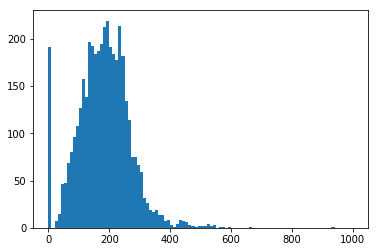

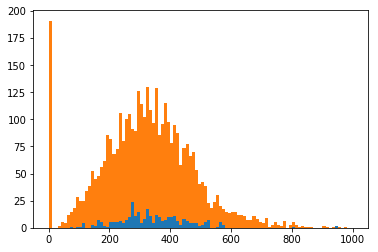

In [81]:
import matplotlib.pyplot as plt

plt.hist(abs_len, bins=np.linspace(0, 1000, 101))
plt.show()
abs_len_tokenized_pos = np.array([abs_len[1] for abs_len in abs_len_tokenized if abs_len[0]==1])
abs_len_tokenized_neg = np.array([abs_len[1] for abs_len in abs_len_tokenized if abs_len[0]==0])
plt.hist(abs_len_tokenized_pos, bins=np.linspace(0, 1000, 101), zorder=2)
plt.hist(abs_len_tokenized_neg, bins=np.linspace(0, 1000, 101), zorder=1)
plt.show()

In [83]:
for data in dataset.dataset:
    if len(tokenizer.tokenize(data.abstract)) > 510:
        print(data.abstract)

Bacteria isolated from surgical infections during the period from April 2011 to March 2012 were investigated in a multicenter study in Japan, and the following results were obtained. In this series, 785 strains including 31 strains of Candida spp. were isolated from 204 (78.8%) of 259 patients with surgical infections. Five hundred and twenty three strains were isolated from primary infections, and 231 strains were isolated from surgical site infection. From primary infections, anaerobic Gram-negative bacteria were predominant, followed by aerobic Gram-negative bacteria, while from surgical site infection aerobic Gram-positive bacteria were predominant, followed by anaerobic Gram-negative bacteria. Among aerobic Gram-positive bacteria, the isolation rate of Enterococcus spp. was highest, followed by Streptococcus spp. and Staphylococcus spp., in this order, from primary infections, while Enterococcus spp. was highest, followed by Staphylococcus spp. from surgical site infection. Among 

limit_output extension: Maximum message size of 10000 exceeded with 27456 characters

# Align and check dataset from @MInter
## Load dataset



In [28]:
"""Currently, we only care about abstract level classification
"""


class SupplementData:

    def __init__(self, supple_dir, silent=False):
        
        def load_abstract_labels(xl):
            abstract_labels = {}
            redundency_log = {}
            for label, pmid in zip(xl['Interaction'], xl['PMID']):
                if pmid in abstract_labels.keys():
                    abstract_labels[pmid] = max(abstract_labels[pmid], label)
                    if pmid in redundency_log.keys():
                        redundency_log[pmid] += str(label)
                    else:
                        redundency_log[pmid] = str(abstract_labels[pmid]) + str(label)
                else:
                    abstract_labels[pmid] = label
            return abstract_labels, redundency_log
            
        if supple_dir[-1] != '/':
            supple_dir += '/'
        if not silent:
            print(util.color.BOLD + util.color.BLUE + \
                  'Load supplement info...' + util.color.END)

        # s1: Core dataset PMIDs
        self.core_dataset = {
            'core_pair': ('lactobacillus acidophilus', 'escherichia coli')
        }
        xl = pd.ExcelFile(supple_dir + 'Supplementary_file_1_Core_Dataset_PMIDs.xlsx')
        xl = xl.parse(xl.sheet_names[0])
        self.core_dataset['abstract_labels'], self.core_dataset['redundency_log'] = load_abstract_labels(xl)
        
        if not silent:
            print("Core dataset:\tCore pair:{}\n\t\tTotal abstract number:{}\n\t\tUnique abstract number:{}\n\t\tw/ interaction:{}\n\t\tredundent:{}".format(
                self.core_dataset['core_pair'],
                len(xl['Interaction']),
                len(self.core_dataset['abstract_labels']),
                np.sum(list(self.core_dataset['abstract_labels'].values())),
                len(self.core_dataset['redundency_log'])
            ))

        # s2: Extended dataset, all pairs of interaction identified, NOT IMPORTANT FOR NOW
        self.ext_dataset = {}
        xl = pd.ExcelFile(supple_dir + 'Supplementary_file_2_Extended_Dataset_Interactions.xlsx')
        xl = xl.parse(xl.sheet_names[0])
        effect_converter = lambda effect: -1 if effect == '-' else 1
        self.ext_dataset['all_pairs'] = {
            (effector.lower(), effectee.lower()): effect_converter(effect)
            for effector, effectee, effect in zip(xl['Effector'], xl['Effectee'], xl['Interaction'])
        }
        if not silent:
            print('Ext. dataset:\tinteraction pairs:{}\n\t\tredundent:{}'.format(
                len(self.ext_dataset['all_pairs']),
                len(xl['Effector']) - len(self.ext_dataset['all_pairs'])
            ))
    
        # s3: Extended dataset, all abstracts
        xl = pd.ExcelFile(supple_dir + 'Supplementary_file_3_Extended_Dataset_PMIDs.xlsx')
        xl = xl.parse(xl.sheet_names[0])
        self.ext_dataset['abstract_labels'], self.ext_dataset['redundency_log'] = load_abstract_labels(xl)
        print("\t\tTotal abstract number:{}\n\t\tUnique abstract number:{}\n\t\tw/ interaction:{}\n\t\tredundent:{}".format(
                len(xl['Interaction']),
                len(self.ext_dataset['abstract_labels']),
                np.sum(list(self.ext_dataset['abstract_labels'].values())),
                len(self.ext_dataset['redundency_log'])
            ))

class CollatedSpFiles:
    """Currently only read info related to abstracts
    """
    
    def __init__(self, collated_dir, silent=False):
        from ref.atminter.lib.modules.paperparse import spFile
        
        print(util.color.BOLD + util.color.BLUE + \
        'Survey the .sp files under {}'.format(collated_dir) + util.color.END)

        import glob

        self.abstracts = {}

        for set_num in [1, 2, 3, 4, 5]:
            files = glob.glob(collated_dir + 'set_{}/*.sp'.format(set_num))
            print("set_{}: number of spFiles: {}".format(set_num, len(files)))
            for file in files:
                sp_file = spFile(spFilePath=file)
                abstract_list = {
                    paper['PMID']: {
                        'title': paper['TI  '],
                        'abstract': paper['AB  ']
                    } for paper in sp_file.papers
                }
                for pmid in abstract_list.keys():
                    if pmid in self.abstracts.keys():
                        if abstract_list[pmid]['title'] != self.abstracts[pmid]['title']:
                            print('Paper info not matching: {}: {} vs. {}'.format(
                                pmid,
                                abstract_list[pmid]['title'],
                                self.abstracts[pmid]['title']
                            ))
                self.abstracts.update(abstract_list)

        print('Number of abstracts with different PMID: {}'.format(len(self.abstracts)))

class atMInterData:
    
    def __init__(self, supple_dir=None, collated_dir=None, silent=False):
        if supple_dir:
            atMInterData.supple_data = SupplementData(supple_dir, silent)
        if collated_dir:
            atMInterData.abstract = CollatedSpFiles(collated_dir, silent)

In [98]:
sp_file.papers[0]

{'AB  ': 'objective: to analyze the cervical microbiota in women with preterm prelabor rupture of membranes (pprom) by pyrosequencing and to document associations between cervical microbiota, cervical inflammatory response, microbial invasion of the amniotic cavity (miac), histological chorioamnionitis, and intraamniotic infection (iai). study design: sixty-one women with singleton pregnancies complicated by pprom were included in the study. specimens of cervical and amniotic fluid were collected on admission. the cervical microbiota was assessed  by 16s rrna gene sequencing by pyrosequencing. interleukin (il)-6 concentration in the cervical fluid and amniotic fluid was measured by elisa and lateral flow immunoassay, respectively. results: four bacterial community state types [cst i (lactobacillus crispatus dominated), cst iii (lactobacillus iners dominated), cst iv-a (non-lactobacillus bacteria dominated), and cst iv-b (gardnerella vaginalis  and sneathia sanguinegens dominated)] were

In [72]:
atMInterData.supple_data.ext_dataset['all_pairs'][(sp_file.species_names[0].lower(), sp_file.species_names[1].lower())]

-1

['here', 'is', 'a', 'sentence', 'to', 'token', '##ize']

## Info reported in supplementary files

In [103]:
MInterData = atMInterData(
    supple_dir='/home/yuning/Work/cs-273/src/ref/atminter/supplement_info/',
    collated_dir='/home/yuning/Work/cs-273/src/ref/atminter/data/train_test_data/collated_annotations/'
)

Load supplement info...
Core dataset:	Core pair:('lactobacillus acidophilus', 'escherichia coli')
		Total abstract number:350
		Unique abstract number:350
		w/ interaction:79
		redundent:0
Ext. dataset:	interaction pairs:59
		redundent:3
		Total abstract number:3567
		Unique abstract number:3454
		w/ interaction:150
		redundent:103
Survey the .sp files under /home/yuning/Work/cs-273/src/ref/atminter/data/train_test_data/collated_annotations/
set_1: number of spFiles: 155
Paper info not matching: 20173067: characterization of a novel lysm domain from lactobacillus fermentum bacteriophage endolysin and its use as an anchor to diplay heterologous proteins on the surfaces of lactic acid bacteria. vs. characterization of a novel lysm domain from lactobacillus fermentum bacteriophage endolysin and its use as an anchor to display heterologous proteins on the surfaces of lactic acid bacteria.
set_2: number of spFiles: 150
set_3: number of spFiles: 153
set_4: number of spFiles: 135
set_5: numbe

In [113]:
for pmid in MInterData.supple_data.core_dataset['abstract_labels'].keys():
    if str(pmid) not in MInterData.abstract.abstracts.keys():
        print("PMID {} not in abstracts".format(pmid))

PMID 25841372 not in abstracts
PMID 25631500 not in abstracts
PMID 25601531 not in abstracts
PMID 25577203 not in abstracts
PMID 25332067 not in abstracts
PMID 25070625 not in abstracts
PMID 25035238 not in abstracts
PMID 25005143 not in abstracts
PMID 24913559 not in abstracts
PMID 24864468 not in abstracts
PMID 24751204 not in abstracts
PMID 24673729 not in abstracts
PMID 24444879 not in abstracts
PMID 24416925 not in abstracts
PMID 24341217 not in abstracts
PMID 24286301 not in abstracts
PMID 24118877 not in abstracts
PMID 24053022 not in abstracts
PMID 23947161 not in abstracts
PMID 23930950 not in abstracts
PMID 23568210 not in abstracts
PMID 23436519 not in abstracts
PMID 23392622 not in abstracts
PMID 23135901 not in abstracts
PMID 23118903 not in abstracts
PMID 23071487 not in abstracts
PMID 23043828 not in abstracts
PMID 22937706 not in abstracts
PMID 22857743 not in abstracts
PMID 22704925 not in abstracts
PMID 22583547 not in abstracts
PMID 22424821 not in abstracts
PMID 220

In [111]:
MInterData.abstract.abstracts.keys()

dict_keys(['14662931', '12656174', '9023920', '8573495', '21304652', '25804061', '23354720', '23263659', '21718151', '21454996', '19651903', '18086839', '18006282', '17692662', '16952957', '16757608', '16407668', '16405692', '16147554', '15959995', '15266908', '15264193', '12855232', '12207212', '12003982', '11952723', '11678931', '11481291', '11184173', '10396687', '9399530', '8878606', '8659081', '7824315', '1344669', '1297243', '15770029', '12485325', '11592487', '17064396', '11699590', '24217692', '21376823', '17983770', '17189093', '12714813', '23040994', '22564451', '16081932', '8182163', '25679309', '9561735', '25829629', '25657101', '25650127', '25533634', '25380795', '25362524', '25244414', '25151879', '25095898', '24962875', '24883178', '24745665', '24695892', '24485676', '24406013', '24341282', '24294233', '24250681', '24020254', '23899653', '23829297', '23810599', '23649523', '23548007', '23541206', '23187955', '23050452', '22916878', '22888666', '22790540', '22559062', '22

limit_output extension: Maximum message size of 10000 exceeded with 346890 characters

## Extended dataset `/data/train_test_data/collated_annotations`

In [23]:
import util
from pprint import pprint
print(util.color.BOLD + util.color.BLUE + \
'Survey the .sp files under subfolders' + util.color.END)

import glob
collated_data_root = '/home/yuning/Work/cs-273/reference/atminter/data/train_test_data/collated_annotations/'
sample_set = []
pair_abstract_set = {}
spFile_counter = 0
redundent = []

for set_num in [1, 2, 3, 4, 5]:
    files = glob.glob(collated_data_root + 'set_{}/*.sp'.format(set_num))
    print("set_{}: number of .sp files: {}".format(set_num, len(files)))
    spFile_counter += len(files)
    for file in files:
        sp_file = spFile(spFilePath=file)
        if tuple(sp_file.species_names) in pair_abstract_set.keys() or tuple((sp_file.species_names[1], sp_file.species_names[0])) in pair_abstract_set.keys():
            redundent.append(tuple(sp_file.species_names))
            pair_abstract_set[tuple((sp_file.species_names[0], sp_file.species_names[1], 1))] = sp_file
        else:
            pair_abstract_set[tuple(sp_file.species_names)] = sp_file
print(util.color.BOLD + util.color.BLUE + \
'Total number of .sp files: {}'.format(spFile_counter) + util.color.END)

print(util.color.BOLD + util.color.BLUE + \
'{} bacteria pairs found redundent in different sets:'.format(len(redundent)) + util.color.END)
pprint(sorted(redundent))

print(util.color.BOLD + util.color.BLUE + \
'Number of abstract with different PMID:' + util.color.END)
papers_PMID_set = set()
for sp_file in pair_abstract_set.values():
    papers_PMID_set.update([paper['PMID'] for paper in sp_file.papers])

print('Number of abstracts with differetn PMID: {}'.format(len(papers_PMID_set)))

Survey the .sp files under subfolders
set_1: number of .sp files: 155
set_2: number of .sp files: 150
set_3: number of .sp files: 153
set_4: number of .sp files: 135
set_5: number of .sp files: 153
Total number of .sp files: 746
16 bacteria pairs found redundent in different sets:
[('Anaerococcus tetradius', 'Salmonella enterica'),
 ('Atopobium vaginae', 'Bacteroides fragilis'),
 ('Bacteroides caccae', 'Faecalibacterium prausnitzii'),
 ('Bacteroides uniformis', 'Bacteroides coprocola'),
 ('Finegoldia magna', 'Clostridiales bacterium'),
 ('Lachnospiraceae bacterium', 'Streptococcus anginosus'),
 ('Lactobacillus amylovorus', 'Lactobacillus casei'),
 ('Paracoccus denitrificans', 'Salmonella enterica'),
 ('Ruminococcus flavefaciens', 'Fusobacterium gonidiaformans'),
 ('Salmonella enterica', 'Paracoccus denitrificans'),
 ('Staphylococcus aureus', 'Desulfovibrio desulfuricans'),
 ('Streptococcus cristatus', 'Capnocytophaga gingivalis'),
 ('Streptococcus infantis', 'Fusobacterium nucleatum'),

In [24]:
sorted(redundent)

[('Anaerococcus tetradius', 'Salmonella enterica'), ('Atopobium vaginae', 'Bacteroides fragilis'), ('Bacteroides caccae', 'Faecalibacterium prausnitzii'), ('Bacteroides uniformis', 'Bacteroides coprocola'), ('Finegoldia magna', 'Clostridiales bacterium'), ('Lachnospiraceae bacterium', 'Streptococcus anginosus'), ('Lactobacillus amylovorus', 'Lactobacillus casei'), ('Paracoccus denitrificans', 'Salmonella enterica'), ('Ruminococcus flavefaciens', 'Fusobacterium gonidiaformans'), ('Salmonella enterica', 'Paracoccus denitrificans'), ('Staphylococcus aureus', 'Desulfovibrio desulfuricans'), ('Streptococcus cristatus', 'Capnocytophaga gingivalis'), ('Streptococcus infantis', 'Fusobacterium nucleatum'), ('Streptococcus oralis', 'Haemophilus influenzae'), ('Yersinia enterocolitica', 'Fusobacterium varium'), ('Zymomonas mobilis', 'Propionibacterium freudenreichii')]

Number of abstracts with differetn PMID: 29948


In [131]:
sp_file.papers

[{'AB  ': 'the objective of this study was to characterize the subgingival microbiota of african-american children with localized aggressive periodontitis (lap). fifty-one children were included. subgingival plaque samples were taken from diseased (dd) and healthy sites (dh) in lap and from healthy sites in hs and hc and analyzed by 16s rrna-based microarrays. aggregatibacter actinomycetemcomitans (aa) was the only species found to be both more prevalent (or = 8.3, p = 0.0025)  and abundant (p < 0.01) in dd. filifactor alocis (fa) was also found to be more prevalent in dd (or 2.31, ci 1.06-5.01, p = 0.03). most prevalent species in healthy sites were selenomonas spp, veillonella spp, streptococcus spp, bergeyella sp, and kingella oralis. overall, streptococcus spp, campylobacter gracilis, capnocytophaga granulosa, haemophilus parainfluenzae, and lautropia mirabilis were most abundant in healthy children, while aa, fa, tannerella sp, solobacterium moorei, parvimonas micra, and capnocyto

In [32]:
sp_file.species_names

['Lactobacillus crispatus', 'Gardnerella vaginalis']

set_1: number of .sp files: 155
set_2: number of .sp files: 150
set_3: number of .sp files: 153
set_4: number of .sp files: 135
set_5: number of .sp files: 153


In [64]:
all_pairs = []
for sample in sample_set:
    sample['pairs'] = [tuple(pair) for pair in sample['pairs']]
    all_pairs += sample['pairs']

In [73]:
import numpy as np
import pprint

repeat_pairs = [(pair,[pair in sample['pairs'] for sample in sample_set]) for pair in set(all_pairs)
                if np.sum([pair in sample['pairs'] for sample in sample_set]) > 1]
pprint.pprint(repeat_pairs)

[(('Streptococcus cristatus', 'Capnocytophaga gingivalis'),
  [True, True, False, False, False]),
 (('Staphylococcus aureus', 'Desulfovibrio desulfuricans'),
  [True, False, True, False, False]),
 (('Bacteroides caccae', 'Faecalibacterium prausnitzii'),
  [False, True, False, True, False]),
 (('Bacteroides uniformis', 'Bacteroides coprocola'),
  [False, False, True, True, False]),
 (('Streptococcus oralis', 'Haemophilus influenzae'),
  [False, False, True, True, False]),
 (('Ruminococcus flavefaciens', 'Fusobacterium gonidiaformans'),
  [True, True, False, False, False]),
 (('Zymomonas mobilis', 'Propionibacterium freudenreichii'),
  [True, False, True, False, False]),
 (('Lactobacillus amylovorus', 'Lactobacillus casei'),
  [False, True, True, False, False]),
 (('Yersinia enterocolitica', 'Fusobacterium varium'),
  [False, False, True, True, False]),
 (('Atopobium vaginae', 'Bacteroides fragilis'),
  [True, False, True, False, False]),
 (('Paracoccus denitrificans', 'Salmonella enteri

In [82]:
file_1 = collated_data_root + 'set_3/Yersinia_enterocolitica#Fusobacterium_varium.sp'
file_2 = collated_data_root + 'set_4/Yersinia_enterocolitica#Fusobacterium_varium.sp'

spFile_1 = spFile(spFilePath=file_1)
spFile_2 = spFile(spFilePath=file_2)

In [83]:
pprint.pprint([paper['PMID'] for paper in spFile_1.papers])
pprint.pprint([paper['PMID'] for paper in spFile_2.papers])

['2875188']
['2875188']
